### Analysis of CROCOd0 simulation

The CROCOd0 simulation is a model solution for the Humboldt current system, on a 3km (1/36°) grid built for the Coquimbo region and its surroundings (~30°S). The grid bathymethry was created with the ~400mx400m GEBCO2022 dataset, and includes 50 vertical levels of terrain following coordinates. The grid parameters $\theta_s$, $\theta_b$ and $hc$ where defined to 7, 2 and 300m, so that vertical levels are distributed with a continuous increase of vertical resolution from deeper (>1000m) to shallower waters (<1000m). 

The results, consists of daily model outputs of a 10 year interannual simulation that began in 2001 and ended in 2011. The atmospheric forcing consists of daily averaged ERA5 fields and the lateral boundary conditions comes from GLORYS12V1 Mercator reanalysis. The experiment, as part of the "ANID-SEQUIA" project, consist of two simulations: the "crocod0_control" and the "crocod0_rivers", where the latter differs only by containing fictitious saline rivers that emulate the discharge of desalination plants.

 The Coquimbo region holds 3 main desalination projects: the Los Vilos (31.89S, 71.51W) industrial plant that will be operational by october 2023 (?), the planned and approved drinking water project of El Panul (30S, 71.42W) and the not yet approved Dominga desalination plant of Totoralillo Norte (29.49S, 71.33W). Following the projected outfall of desalination plants for the Coquimbo region (Vicuña, S., et al Desalinización: ...) the discharge was distributed equally for the three saline rivers with a constant value of 1.3 $m^{3}s^{-1}$, salinities up to 60 PSU and temperatures equal to the local enviroment. 

The current jupyter notebook contains the postprocess and analysis of the control simulation and the main differences that comes with the saline rivers simulation. The results constits of an evaluation of salt accumulation on the long term and the expected spatial differences, the coastal changes of the seasonal cycle of salinity, the surface and depth differences in stratification, currents and salinity in the near field and the definition of an average area of influence for the desalination brine. 


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *


In [2]:
# Load rund0 grid
gridd0 = xr.open_dataset('data/DESALADORAS_RUND0/crocod0_grd.nc').load()

In [3]:
# Load croco control simulation
paths   = glob('data/DESALADORAS_RUND0/*avg*')[24:]
control = xr.open_mfdataset(paths, parallel=True)[['hbl','zeta','u','v','salt','temp']]
control = center_crocogrid(control, control.keys())
control = fix_crocotime(control, YORIG='1949-12-31')


In [ ]:
# Load croco rivers simulation
paths   = glob('data/DESALADORAS_RUND0_RIOS/*avg*')
rivers  = xr.open_mfdataset(paths, parallel=True)[['hbl','zeta','u','v','temp','salt']]
rivers  = center_crocogrid(rivers, rivers.keys())
rivers  = fix_crocotime(rivers, YORIG='1949-12-31')


In [21]:
u,v = control.isel(s_rho=-1).sel(time='2001').u.load(), control.isel(s_rho=-1).sel(time='2001').v.load()

control_eke = (u.groupby('time.month')-u.groupby('time.month').mean('time'))**2+(v.groupby('time.month')-v.groupby('time.month').mean('time'))**2
control_eke = control_eke*0.5
control_eke = control_eke.mean('time')

(-32.5, -28.5)

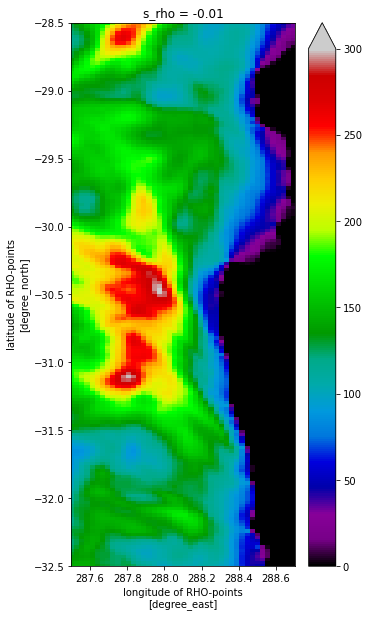

In [28]:
# gridd0.mask_rho.where(gridd0.mask_rho==0).plot()
(1e4*control_eke).plot(x='lon_rho',y='lat_rho', cmap='nipy_spectral', zorder=1, vmin=0, vmax=300, figsize=(5,10))
plt.xlim(287.5,288.7)
plt.ylim(-32.5,-28.5)

In [5]:
gridArea = gridd0.x_rho.differentiate('xi_rho')*gridd0.y_rho.differentiate('eta_rho')
gridArea = gridArea.load()

In [6]:
# Grab sea surface salinity (nearest sigma level to surface)
sss_control = control.salt.isel(s_rho=-1).load()
sss_rivers  = rivers.salt.isel(s_rho=-1).load()

In [7]:
#Grab salinity on an intermediate sigma surface
saltcontrol_sigma25 = control.salt.isel(s_rho=-25).load()
saltrivers_sigma25  = rivers.salt.isel(s_rho=-25).load()

In [8]:
#Grab salinity near the ocean bottom (last sigma surface)
saltcontrol_sigma50 = control.salt.isel(s_rho=0).load()
saltrivers_sigma50  = rivers.salt.isel(s_rho=0).load()

In [9]:
#Compute accumulated salt along vertical dimension to get a total 2D view
saltcontrol_2Dcum = control.salt.mean('s_rho').load()
saltrivers_2Dcum  = rivers.salt.mean('s_rho').load()

In [24]:
#Compute percentual difference between control and saline river simulation
diff_2Dcum   = (((saltrivers_2Dcum-saltcontrol_2Dcum).mean('time')))
diff_surface = (sss_rivers-sss_control).mean('time')
diff_sigma25 = ((saltrivers_sigma25-saltcontrol_sigma25).mean('time'))
diff_sigma50 = ((saltrivers_sigma50-saltcontrol_sigma50).mean('time'))

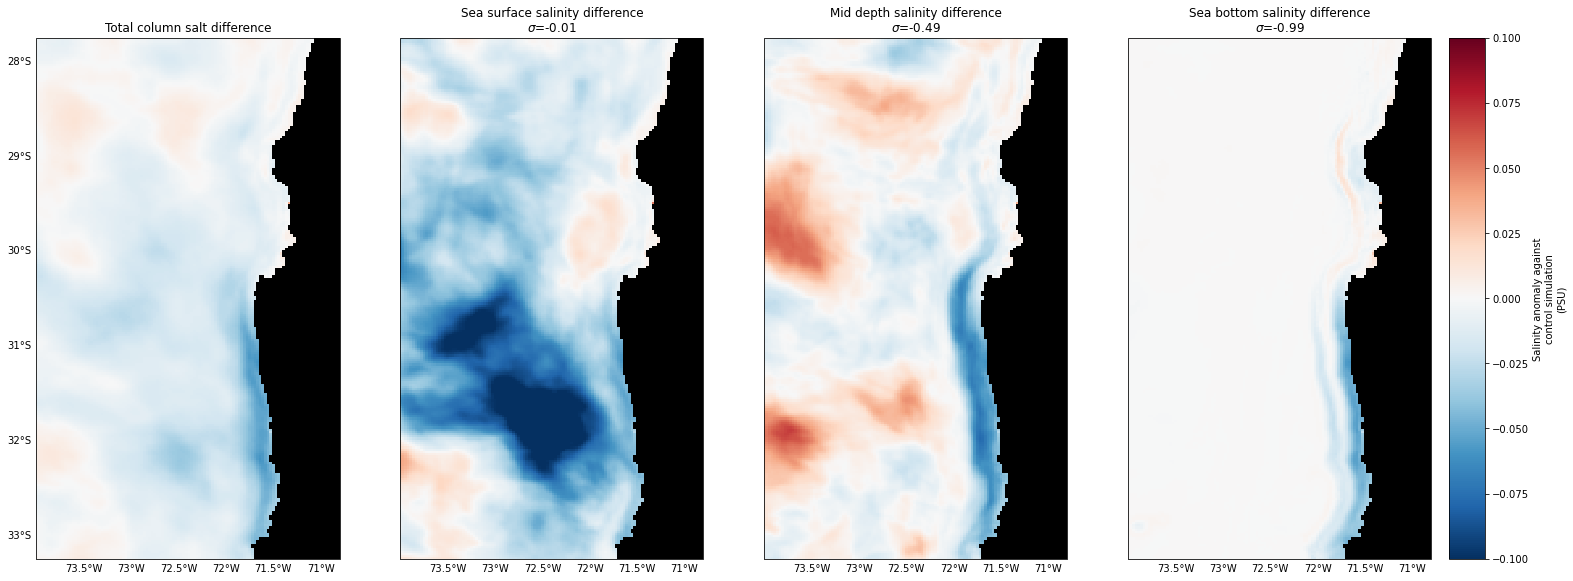

In [11]:
plt.rc('font', size=12)
plt.rc('hatch', color='k')

titles = ['Total column salt difference','Sea surface salinity difference\n$\sigma$=-0.01', 'Mid depth salinity difference\n$\sigma$=-0.49', 'Sea bottom salinity difference\n$\sigma$=-0.99']
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(25,15),
                       subplot_kw={'projection':ccrs.PlateCarree()})
for i,axis in enumerate(ax.ravel()):
    axis.set_title(titles[i])
    axis.pcolormesh(gridd0.lon_rho, gridd0.lat_rho, gridd0.mask_rho.where(gridd0.mask_rho==0), cmap='bone',zorder=1)
    axis.set_extent([-74,-70.8,-33.25,-27.75])
    gl = axis.gridlines(draw_labels=True, linewidth=0)
    gl.top_labels=False
    gl.right_labels=False
    if i>0:
        gl.left_labels=False
        
vmin,vmax=-0.1,0.1
hatchtype='//'
cmap='RdBu_r'
ttime = '2011'
# -------------------------------- PLOT BIASES ------------------------------- #

m = ((saltrivers_2Dcum-saltcontrol_2Dcum)).sel(time=ttime).mean('time').plot(
        ax=ax[0], add_labels=False, add_colorbar=False,
        x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)

(sss_rivers-sss_control).sel(time=ttime).mean('time').plot(
    ax=ax[1], add_labels=False, add_colorbar=False,
    x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)


(saltrivers_sigma25-saltcontrol_sigma25).sel(time=ttime).mean('time').plot(
    ax=ax[2], add_labels=False, add_colorbar=False,
    x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)


(saltrivers_sigma50-saltcontrol_sigma50).sel(time=ttime).mean('time').plot(
    ax=ax[3], add_labels=False, add_colorbar=False,
    x='lon_rho', y='lat_rho', transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax, zorder=0, cmap=cmap)


# --------------------------- PLOT SIGNIFICANT RMSE -------------------------- #

#Find places where RMSE(rivers,control)>=1.25*std(control)
# important_2dcum   = (((saltrivers_2Dcum-saltcontrol_2Dcum))**2).sel(time=ttime).mean('time')**0.5     >= 1.0*saltcontrol_2Dcum.sel(time=ttime).std('time')
# important_surface = ((sss_rivers-sss_control)**2).sel(time=ttime).mean('time')**0.5                   >= 1.0*sss_control.sel(time=ttime).std('time')
# important_sigma25 = (((saltrivers_sigma25-saltcontrol_sigma25)**2).sel(time=ttime).mean('time'))**0.5 >= 1.0*saltcontrol_sigma25.sel(time=ttime).std('time')
# important_sigma50 = (((saltrivers_sigma50-saltcontrol_sigma50)**2).sel(time=ttime).mean('time'))**0.5 >= 1.0*saltcontrol_sigma50.sel(time=ttime).std('time')

# important_2dcum.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[0],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# important_surface.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[1],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# important_sigma25.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[2],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# important_sigma50.where(gridd0.mask_rho==1).plot.contourf(
#     add_labels=False, add_colorbar=False,levels=[-1,0,1], ax=ax[3],
#     x='lon_rho', y='lat_rho', hatches=['',hatchtype], cmap='none',
#     transform=ccrs.PlateCarree())

# --------------------------------- COLORBAR --------------------------------- #

bbox = ax[-1].get_position()
cax  = fig.add_axes([bbox.xmax+0.01, bbox.ymin, 0.02, bbox.ymax-bbox.ymin])
fig.colorbar(m, cax=cax, label='Salinity anomaly against\ncontrol simulation\n(PSU)')

In [12]:
ts_rivers  = saltrivers_sigma50.sel(eta_rho=169,xi_rho=132).load()
ts_control = saltcontrol_sigma50.sel(eta_rho=169,xi_rho=132).load()

# ts_rivers  = saltrivers_sigma50.sel(eta_rho=68,xi_rho=126).load()
# ts_control = saltcontrol_sigma50.sel(eta_rho=68,xi_rho=126).load()

  

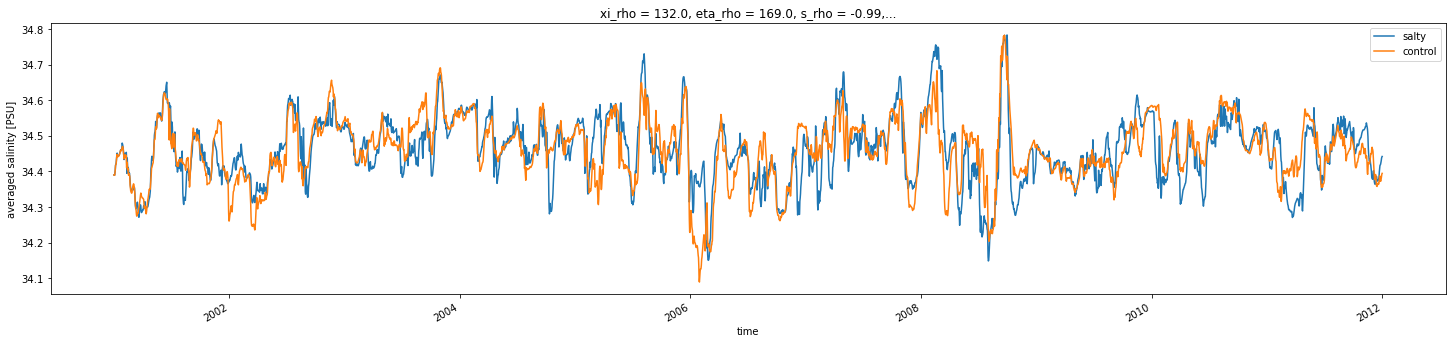

In [13]:
plt.figure(figsize=(25,5))
ts_rivers.plot(label='salty')
ts_control.plot(label='control')
plt.legend()

DJF
JJA
MAM
SON


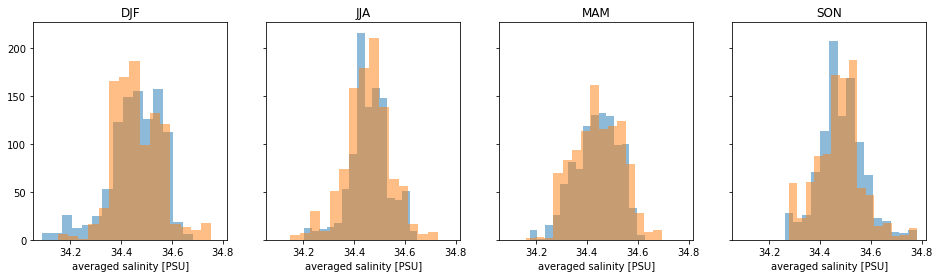

In [14]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,4))

for t,(i,g) in zip(range(4),ts_control.groupby('time.season')):
    print(i)
    g.plot.hist(ax=ax[t], bins=15, alpha=0.5)
    
for t,(i,g) in zip(range(4),ts_rivers.groupby('time.season')):
    g.plot.hist(ax=ax[t], bins=15, alpha=0.5)
    ax[t].set_title(i)

In [ ]:

xx = ((saltrivers_sigma50-saltcontrol_sigma50).std('time'))
yy = ((saltrivers_sigma25-saltcontrol_sigma25).std('time'))
zz = (sss_rivers-sss_control).std('time')
ww = (((saltrivers_2Dcum-saltcontrol_2Dcum).std('time')))

In [27]:
import scipy

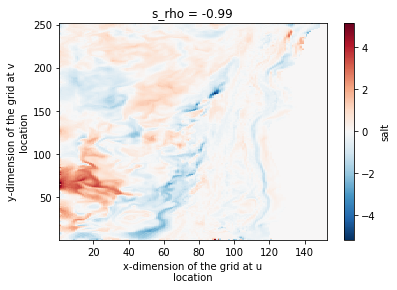

In [29]:
(saltrivers_sigma50-saltcontrol_sigma50).reduce(func=scipy.stats.skew, dim='time').plot()

In [25]:
x = diff_sigma50
y = diff_sigma25
z = diff_surface
w = diff_2Dcum




xx = ((saltrivers_sigma50-saltcontrol_sigma50).std('time'))
yy = ((saltrivers_sigma25-saltcontrol_sigma25).std('time'))
zz = (sss_rivers-sss_control).std('time')
ww = (((saltrivers_2Dcum-saltcontrol_2Dcum).std('time')))


valx = xr.concat([x.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')
valy = xr.concat([y.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')
valz = xr.concat([z.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')
valw = xr.concat([w.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')

valxx = xr.concat([xx.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')
valyy = xr.concat([yy.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')
valzz = xr.concat([zz.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')
valww = xr.concat([ww.where(gridd0.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(252)], 'eta_rho')

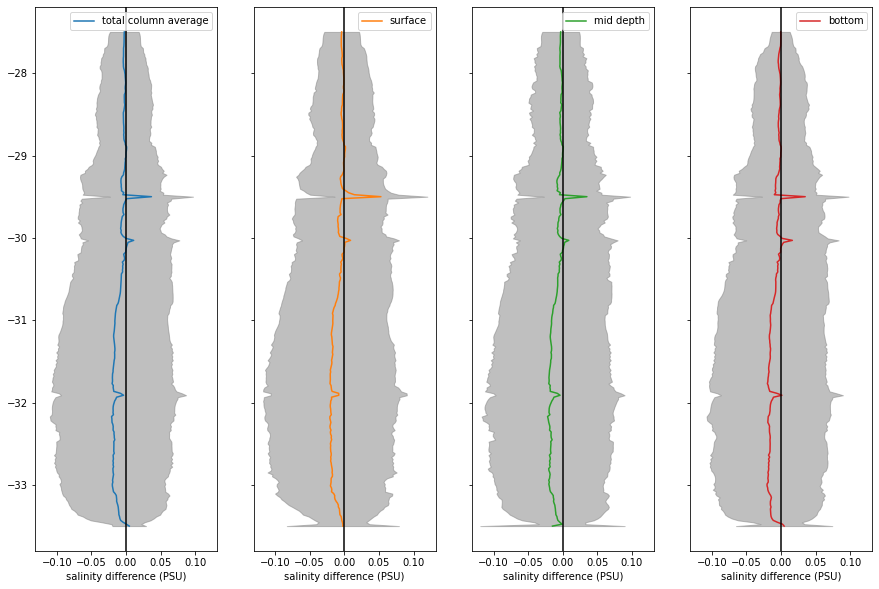

In [26]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(15,10))

ax[0].plot(valw,valw.lat_rho, label='total column average')
ax[1].plot(valz,valw.lat_rho, label='surface', color='tab:orange')
ax[2].plot(valy,valw.lat_rho, label='mid depth', color='tab:green')
ax[3].plot(valx,valw.lat_rho, label='bottom', color='tab:red')

ax[0].fill_betweenx(valw.lat_rho, valw+valww,valw-valww, color='grey', alpha=0.5)
ax[1].fill_betweenx(valw.lat_rho, valz+valzz,valz-valzz, color='grey', alpha=0.5)
ax[2].fill_betweenx(valw.lat_rho, valy+valyy,valy-valyy, color='grey', alpha=0.5)
ax[3].fill_betweenx(valw.lat_rho, valx+valxx,valx-valxx, color='grey', alpha=0.5)

for axis in ax.ravel():
    axis.axvline(0, color='k', ls="-")
    axis.legend()
    axis.set_xlabel('salinity difference (PSU)')

---

In [12]:
z_rho = rhopoints_depths(gridd0.h.expand_dims(dim={'s_rho':control.s_rho}), control.zeta, control.s_rho, xr.DataArray(control.Cs_r, coords={'s_rho':control.s_rho}), control.hc)
z_rho = z_rho.mean('time').load()

In [16]:
tlat = -29.49
teta = np.nanargmin((control.lat_rho[:,-1]-tlat)**2)

In [17]:
from seawater.eos80 import dens, dens0
tlat = -29.49
teta = np.nanargmin((control.lat_rho[:,0]-tlat)**2)

section_control = control[['salt','temp']].sel(eta_rho=teta).compute()
section_rivers  = rivers[['salt','temp']].sel(eta_rho=teta).compute()

section_control['rho'] = xr.apply_ufunc(dens0, section_control.salt, section_control.temp)
section_rivers['rho']  = xr.apply_ufunc(dens0, section_rivers.salt, section_rivers.temp)
section_difference     = (section_rivers-section_control)

In [18]:
important_diffs = ((section_difference)**2).mean('time')**0.5 >= 1.2*(section_control.std('time'))
important_diffs.coords['z'] = z_rho.sel(eta_rho=teta).copy()

(287.0, 288.5)

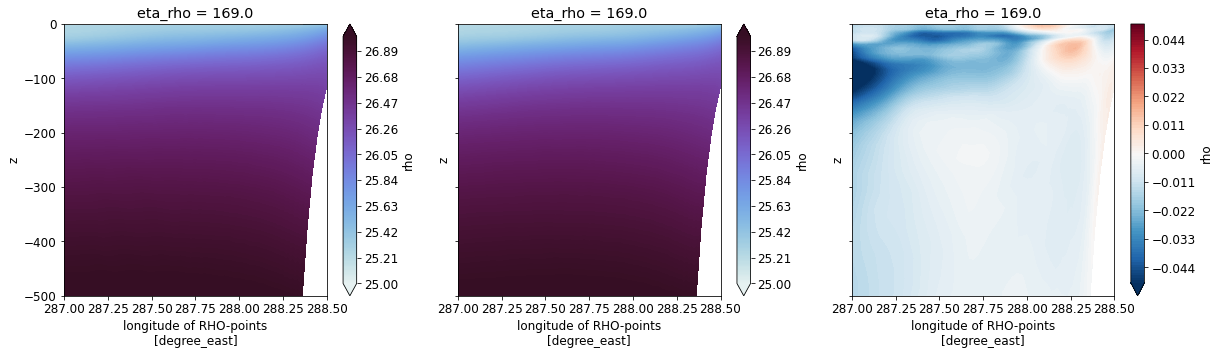

In [19]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,5))

x = section_control.rho.sel(time=slice('2009','2011')).mean('time')-1000
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap=cmocean.cm.dense, ax=ax[0], levels=np.arange(25,27+0.01,0.01))

x = section_rivers.rho.sel(time=slice('2009','2011')).mean('time')-1000
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap=cmocean.cm.dense, ax=ax[1], levels=np.arange(25,27+0.01,0.01))

x = section_difference.rho.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap='RdBu_r', ax=ax[2], levels=np.arange(-0.05,0.05+0.001,0.001))


# important_diffs.where(important_diffs>0).rho.plot.contourf(ax=ax[2],
#                                                             cmap='none',
#                                                             add_colorbar=False,
#                                                             hatches=['',hatchtype],
#                                                             levels=[-1,0,1],
#                                                             y='z', x='lon_rho')

plt.ylim(-500,0)
plt.xlim(287,288.5)

(287.0, 288.5)

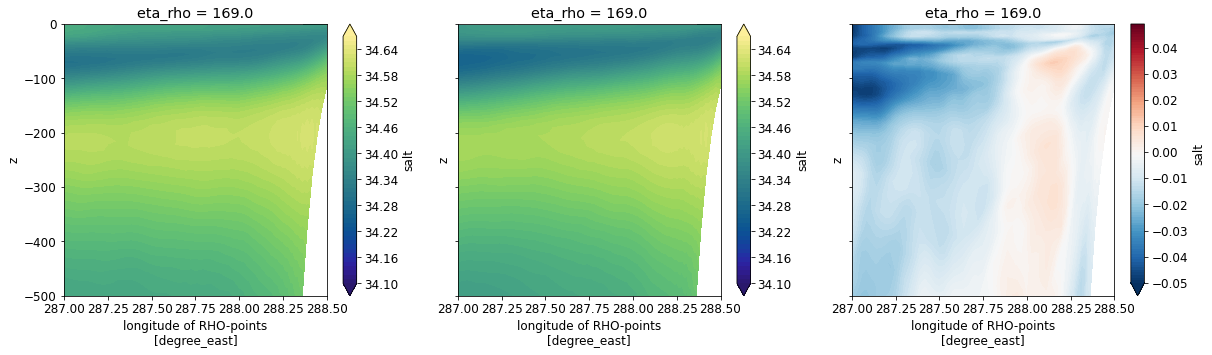

In [20]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,5))

x = section_control.salt.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap=cmocean.cm.haline, ax=ax[0], levels=np.arange(34.1,34.68,0.01))

x = section_rivers.salt.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap=cmocean.cm.haline, ax=ax[1], levels=np.arange(34.1,34.68,0.01))

x = section_difference.salt.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap='RdBu_r', ax=ax[2], levels=np.arange(-0.05,0.05,0.001))


# important_diffs.where(important_diffs>0).salt.plot.contourf(ax=ax[2],
#                                                             cmap='none',
#                                                             add_colorbar=False,
#                                                             hatches=['',hatchtype],
#                                                             levels=[-1,0,1],
#                                                             y='z', x='lon_rho')


plt.ylim(-500,0)
plt.xlim(287,288.5)

(287.0, 288.5)

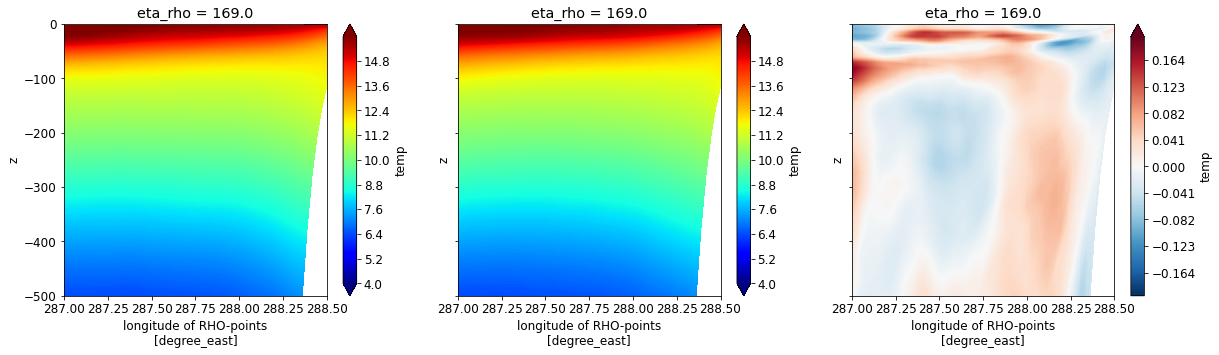

In [21]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,5))

x = section_control.temp.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap='jet', ax=ax[0], levels=np.arange(4,16,0.01))

x = section_rivers.temp.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap='jet', ax=ax[1], levels=np.arange(4,16,0.01))

x = section_difference.temp.sel(time=slice('2009','2011')).mean('time')
x.coords['z'] = z_rho.sel(eta_rho=teta).copy()
x.plot.contourf(y='z',x='lon_rho', cmap='RdBu_r', ax=ax[2], levels=np.arange(-0.2,0.2+0.001,0.001))

# important_diffs.where(important_diffs>0).temp.plot.contourf(ax=ax[2],
#                                                             cmap='none',
#                                                             add_colorbar=False,
#                                                             hatches=['',hatchtype],
#                                                             levels=[-1,0,1],
#                                                             y='z', x='lon_rho')

plt.ylim(-500,0)
plt.xlim(287,288.5)